# data preprocessing

In [1]:
import re
import pickle
from collections import Counter

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from soynlp.normalizer import repeat_normalize
from PIL import Image
from tqdm.notebook import tqdm

from utils import get_khaiii_api, load_json, pos_text, stemming_text
from tokenizer import Tokenizer


cfg = load_json("config.json")

2021-11-12 12:24:30.886214: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
api = get_khaiii_api('/mnt/subdisk/workspace/khaiii/build/share/khaiii')

In [3]:
df = pd.read_excel(cfg['output_dir'] + "/ine_coment.xlsx")
df.head()

,title,desc,name,time,comment
0,방송의 5할이 먹는 이야기,20210913. 20211024 아이네의 최애 버거는? 아이네 생방송: http...,한량프로,2021-11-11 07:52:37,잘 먹고 건강만 해다오 ㅋㅋㅋㅋㅋㅋㅋㅋ
1,방송의 5할이 먹는 이야기,20210913. 20211024 아이네의 최애 버거는? 아이네 생방송: http...,권재혁,2021-11-11 07:51:59,호오... 아이네상... 꽤 높은 먹투력이군요...
2,방송의 5할이 먹는 이야기,20210913. 20211024 아이네의 최애 버거는? 아이네 생방송: http...,릅릅,2021-11-11 07:49:29,0:51 백신맞고와서 뽀로로밴드 붙인거네ㅋㅋㅋ
3,방송의 5할이 먹는 이야기,20210913. 20211024 아이네의 최애 버거는? 아이네 생방송: http...,이로운,2021-11-11 07:47:29,재밌는 영상 감사합니다 잘 볼게용
4,방송의 5할이 먹는 이야기,20210913. 20211024 아이네의 최애 버거는? 아이네 생방송: http...,오월비 MayB,2021-11-11 07:47:26,아니 어떻게 트러플 머쉬룸 와퍼가 단종되지???!! 진짜 어이없네…


In [4]:
def normalize(text):
    text = text.replace("_x000D_", " ")
    text = text.replace("\n", " ")
    text = text.replace("넴", "님")
    text = text.replace("는데", "다")
    text = text.replace("아니네", "아이네")
    text = text.replace("해미네", "햄이네")
    text = re.sub("http[s]?://(?:[a-zA-Z]|[0-9]|[$\-@\.&+:/?=]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+", "", text)
    text = re.sub(r'\d+(:\d+)+|[^ 가-힣0-9]', r' ', text)
    text = repeat_normalize(text, 3)
    text = re.sub(r'(.{3,}?)\1+', r'\1', text)
    return text.strip()

df = df[df['name'] != '아이네 INE']
df['comment'] = df['comment'].apply(normalize)
df = df[df['comment'].str.len() > 1]
df.head(5)

,title,desc,name,time,comment
0,방송의 5할이 먹는 이야기,20210913. 20211024 아이네의 최애 버거는? 아이네 생방송: http...,한량프로,2021-11-11 07:52:37,잘 먹고 건강만 해다오
1,방송의 5할이 먹는 이야기,20210913. 20211024 아이네의 최애 버거는? 아이네 생방송: http...,권재혁,2021-11-11 07:51:59,호오 아이네상 꽤 높은 먹투력이군요
2,방송의 5할이 먹는 이야기,20210913. 20211024 아이네의 최애 버거는? 아이네 생방송: http...,릅릅,2021-11-11 07:49:29,백신맞고와서 뽀로로밴드 붙인거네
3,방송의 5할이 먹는 이야기,20210913. 20211024 아이네의 최애 버거는? 아이네 생방송: http...,이로운,2021-11-11 07:47:29,재밌는 영상 감사합니다 잘 볼게용
4,방송의 5할이 먹는 이야기,20210913. 20211024 아이네의 최애 버거는? 아이네 생방송: http...,오월비 MayB,2021-11-11 07:47:26,아니 어떻게 트러플 머쉬룸 와퍼가 단종되지 진짜 어이없네


In [5]:
pos_tagged_corpus = pos_text(df.comment, api)
df['processed_comment'] = stemming_text(pos_tagged_corpus)

In [6]:
df['processed_comment']

0                          잘/MAG 먹다/VV 건강/NNG 하다/VV 오/NNG
1                 호오/NNP 아이네/NNP 상/NNG 꽤/MAG 높/VA 먹투력/NNG
2                          백신맞/NNG 뽀로로밴드/NNG 붙이다/VV 거/NNG
3                  재밌/VA 영상/NNG 감사하다/VV 잘/MAG 볼/NNG 용/NNG
4       어떻/VA 트/NNG 러다/VV 플/NNG 머쉬룸/NNG 와퍼/NNG 단종되다/VV...
                              ...                        
8268                                                     
8270                                      아이네/NNP 아이네/NNP
8271                                        앙/NNP 구독띠/NNG
8272                                                     
8273                          빠/NNB 당/NNG 아이네/NNP 파이팅/NNG
Name: processed_comment, Length: 7753, dtype: object

In [7]:
df['processed_comment'] = df['processed_comment'].apply(
    lambda x: ' '.join(
        [
            w.split('/')[0] 
            for w in x.split() 
            if w.split('/')[1] in ['NNG', 'NNP', 'VV', 'VA', 'MAG', 'MAJ']
        ]
    )
)
df = df[df['processed_comment'] != ""]
df.head()

,title,desc,name,time,comment,processed_comment
0,방송의 5할이 먹는 이야기,20210913. 20211024 아이네의 최애 버거는? 아이네 생방송: http...,한량프로,2021-11-11 07:52:37,잘 먹고 건강만 해다오,잘 먹다 건강 하다 오
1,방송의 5할이 먹는 이야기,20210913. 20211024 아이네의 최애 버거는? 아이네 생방송: http...,권재혁,2021-11-11 07:51:59,호오 아이네상 꽤 높은 먹투력이군요,호오 아이네 상 꽤 높 먹투력
2,방송의 5할이 먹는 이야기,20210913. 20211024 아이네의 최애 버거는? 아이네 생방송: http...,릅릅,2021-11-11 07:49:29,백신맞고와서 뽀로로밴드 붙인거네,백신맞 뽀로로밴드 붙이다 거
3,방송의 5할이 먹는 이야기,20210913. 20211024 아이네의 최애 버거는? 아이네 생방송: http...,이로운,2021-11-11 07:47:29,재밌는 영상 감사합니다 잘 볼게용,재밌 영상 감사하다 잘 볼 용
4,방송의 5할이 먹는 이야기,20210913. 20211024 아이네의 최애 버거는? 아이네 생방송: http...,오월비 MayB,2021-11-11 07:47:26,아니 어떻게 트러플 머쉬룸 와퍼가 단종되지 진짜 어이없네,어떻 트 러다 플 머쉬룸 와퍼 단종되다 진짜 어이없


# draw wordcloud

In [8]:
all_tokens = sum(df['processed_comment'].apply(lambda x: x.split()), [])

In [9]:
counter = Counter(all_tokens)

counter.most_common(10)

[('아이네', 1401),
 ('너무', 970),
 ('좋', 805),
 ('하다', 780),
 ('보다', 768),
 ('있다', 432),
 ('진짜', 420),
 ('킹아', 388),
 ('주다', 346),
 ('귀엽', 344)]

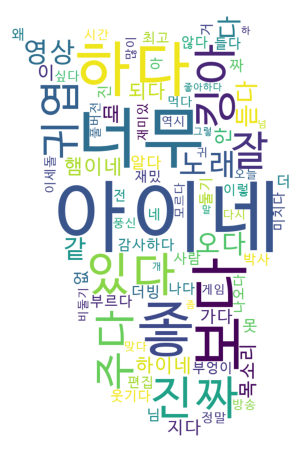

In [10]:
bgimg = Image.open('resource/wakdoo.png')
mask = np.array(bgimg)

wc = WordCloud(font_path=cfg['font_path'],background_color="white", max_font_size=200, mask=mask)
cloud = wc.generate_from_frequencies(dict(counter.most_common(80)))
cloud.to_file("resource/wordcloud.png")

plt.figure(figsize=(10, 8))
plt.axis('off')
plt.imshow(cloud)
plt.show()

# tokenizer

In [11]:
tokens = ["[PAD]", "[UNK]"] + [t[0] for t in counter.most_common(len(counter))]

with open("resource/tokenizer.pkl", "wb") as f:
    pickle.dump({k: i for i, k in enumerate(tokens)}, f)

In [12]:
tokenizer = Tokenizer("resource/tokenizer.pkl")

In [13]:
sample_text = df.iloc[0, -1]

print(sample_text)
print(tokenizer.encode(sample_text))

잘 먹다 건강 하다 오
[12, 62, 1258, 5, 125]


# word 2 Vec

In [24]:
targets, contexts, labels = [], [], []

sampling_table = tf.keras.preprocessing.sequence.make_sampling_table(tokenizer.vocab_size)

In [25]:
for text in tqdm(df.processed_comment):
    sequence = tokenizer.encode(text)
    if len(sequence) < cfg['num_negative_samples'] * 2 + 1:
        continue
    
    positive_skip_grams, _ = tf.keras.preprocessing.sequence.skipgrams(
        sequence,
        vocabulary_size=tokenizer.vocab_size,
        sampling_table=sampling_table,
        window_size=cfg['window_size'],
        negative_samples=0
    )

    for target_word, context_word in positive_skip_grams:
        context_class = tf.expand_dims(tf.constant([context_word], dtype="int64"), 1)
        negative_sampling_candidates, _, _ = tf.random.log_uniform_candidate_sampler(
            true_classes=context_class,
            num_true=1,
            num_sampled=cfg['num_negative_samples'],
            unique=True,
            range_max=tokenizer.vocab_size,
            seed=cfg['random_seed'],
            name="negative_sampling"
        )

        negative_sampling_candidates = tf.expand_dims(negative_sampling_candidates, 1)

        context = tf.concat([context_class, negative_sampling_candidates], 0)
        label = tf.constant([1] + [0] * cfg['num_negative_samples'], dtype="int64")

        targets.append(target_word)
        contexts.append(context)
        labels.append(label)

In [27]:
targets = np.array(targets)
contexts = np.array(contexts)[:,:,0]
labels = np.array(labels)

targets.shape, contexts.shape, labels.shape

((14030,), (14030, 5), (14030, 5))